In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib.ticker import FuncFormatter
matplotlib.style.use('ggplot')
import sqlite3 
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [17]:
mta = pd.read_csv('Turnstile_Usage_Data__2022.csv', sep = ',',header = None)

# Присвоение имен столбцов
mta.columns = ['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Division', 'Date', 'Time', 'Description', 'Entries', 'Exits']

# mta.columns =['C/A','unit','SCP','Station','date','time','desc','entries','exits']

# Оставляем только нужные столбцы
mta = mta[['C/A', 'Unit', 'SCP', 'Station', 'Date', 'Time', 'Description', 'Entries', 'Exits']]
mta = mta.drop(index=0)
print(mta.head())

    C/A  Unit       SCP Station        Date      Time Description  Entries  \
1  A002  R051  02-00-00   59 ST  01/01/2022  03:00:00     REGULAR  7675872   
2  A002  R051  02-00-00   59 ST  01/01/2022  07:00:00     REGULAR  7675876   
3  A002  R051  02-00-00   59 ST  01/01/2022  11:00:00     REGULAR  7675887   
4  A002  R051  02-00-00   59 ST  01/01/2022  15:00:00     REGULAR  7675895   
5  A002  R051  02-00-00   59 ST  01/01/2022  19:00:00     REGULAR  7675920   

     Exits  
1  2649548  
2  2649551  
3  2649594  
4  2649626  
5  2649657  


In [19]:
mta['datetime'] = pd.to_datetime(mta.Date + ' ' + mta.Time, format='%m/%d/%Y  %H:%M:%S')
mta['turnstile'] = mta['C/A'] + '-' + mta['Unit'] + '-' + mta['SCP']

mta = mta[(mta.datetime >= '01-01-18 00:00:00') & 
          (mta.datetime <'07-01-26 00:00:00')]

mta.head()

,C/A,Unit,SCP,Station,Date,Time,Description,Entries,Exits,datetime,turnstile
1,A002,R051,02-00-00,59 ST,01/01/2022,03:00:00,REGULAR,7675872,2649548,2022-01-01 03:00:00,A002-R051-02-00-00
2,A002,R051,02-00-00,59 ST,01/01/2022,07:00:00,REGULAR,7675876,2649551,2022-01-01 07:00:00,A002-R051-02-00-00
3,A002,R051,02-00-00,59 ST,01/01/2022,11:00:00,REGULAR,7675887,2649594,2022-01-01 11:00:00,A002-R051-02-00-00
4,A002,R051,02-00-00,59 ST,01/01/2022,15:00:00,REGULAR,7675895,2649626,2022-01-01 15:00:00,A002-R051-02-00-00
5,A002,R051,02-00-00,59 ST,01/01/2022,19:00:00,REGULAR,7675920,2649657,2022-01-01 19:00:00,A002-R051-02-00-00


In [21]:
print('Descriptions of entries:')
print(mta['Entries'].describe())
print('')
print('Descriptions of exits:')
print(mta['Exits'].describe())

Descriptions of entries:
count     10963251
unique     5509961
top              0
freq        158552
Name: Entries, dtype: int64

Descriptions of exits:
count     10963251
unique     4975594
top              0
freq        438410
Name: Exits, dtype: int64


In [25]:
# group data by turnstile, sort each turnstile by datetime
# Create new columns en_diff and ex_diff for each unique turnstile
# turn cumulative counts into counts per interval

# Преобразование столбцов к числовому типу
mta['Entries'] = pd.to_numeric(mta['Entries'], errors='coerce')
mta['Exits'] = pd.to_numeric(mta['Exits'], errors='coerce')

mta_sorted = mta.sort_values(['turnstile', 'datetime'])
mta_sorted = mta_sorted.reset_index(drop = True)

turnstile_grouped = mta_sorted.groupby(['turnstile'])

mta_sorted['entries_diff'] = turnstile_grouped['Entries'].transform(pd.Series.diff)
mta_sorted['exits_diff'] = turnstile_grouped['Exits'].transform(pd.Series.diff)

mta_sorted.head()

,C/A,Unit,SCP,Station,Date,Time,Description,Entries,Exits,datetime,turnstile,entries_diff,exits_diff
0,A002,R051,02-00-00,59 ST,01/01/2022,03:00:00,REGULAR,7675872,2649548,2022-01-01 03:00:00,A002-R051-02-00-00,NaN,NaN
1,A002,R051,02-00-00,59 ST,01/01/2022,07:00:00,REGULAR,7675876,2649551,2022-01-01 07:00:00,A002-R051-02-00-00,4.0,3.0
2,A002,R051,02-00-00,59 ST,01/01/2022,11:00:00,REGULAR,7675887,2649594,2022-01-01 11:00:00,A002-R051-02-00-00,11.0,43.0
3,A002,R051,02-00-00,59 ST,01/01/2022,15:00:00,REGULAR,7675895,2649626,2022-01-01 15:00:00,A002-R051-02-00-00,8.0,32.0
4,A002,R051,02-00-00,59 ST,01/01/2022,19:00:00,REGULAR,7675920,2649657,2022-01-01 19:00:00,A002-R051-02-00-00,25.0,31.0


In [26]:
# check distribution of entries_diff and exits_diff
print('Descriptions of entries_diff:')
print(mta_sorted['entries_diff'].describe())
print('')
print('Descriptions of exits_diff:')
print(mta_sorted['exits_diff'].describe())

Descriptions of entries_diff:
count    1.095814e+07
mean    -4.175053e+02
std      2.787198e+06
min     -2.146430e+09
25%      4.000000e+00
50%      2.600000e+01
75%      8.800000e+01
max      2.146430e+09
Name: entries_diff, dtype: float64

Descriptions of exits_diff:
count    1.095814e+07
mean    -5.498219e+02
std      2.668781e+06
min     -2.147345e+09
25%      7.000000e+00
50%      3.700000e+01
75%      1.130000e+02
max      2.147345e+09
Name: exits_diff, dtype: float64


In [27]:
print('Number of negative entries_diff: %d' %len(mta_sorted['entries_diff'][mta_sorted['entries_diff'] < 0]))
print('Number of negative exits_diff: %d' %len(mta_sorted['exits_diff'][mta_sorted['exits_diff'] < 0]))
print('Number of unqiue turnstiles: %d' %len(mta_sorted['turnstile'].unique()))
print('Number of NaN rows: %d' %len(mta_sorted[mta_sorted['entries_diff'].isnull()]))

Number of negative entries_diff: 105866
Number of negative exits_diff: 63269
Number of unqiue turnstiles: 5107
Number of NaN rows: 5107


In [28]:
mta_sorted['entries_diff'] = mta_sorted['entries_diff'].fillna(0)
mta_sorted['exits_diff'] = mta_sorted['exits_diff'].fillna(0)

mta_sorted['entries_diff'][mta_sorted['entries_diff'] < 0] = 0 
mta_sorted['exits_diff'][mta_sorted['exits_diff'] < 0] = 0 

mta_sorted['entries_diff'][mta_sorted['entries_diff'] >= 6000] = 0 
mta_sorted['exits_diff'][mta_sorted['exits_diff'] >= 6000] = 0

In [29]:
mta_h1 = mta_sorted[['turnstile','Station', 'datetime','Date','Time', 'entries_diff','exits_diff']]
mta_h1['busy'] = mta_h1['entries_diff'].values + mta_h1['exits_diff'].values

del [mta_sorted]
mta_h1.shape

(10963251, 8)

In [30]:
mta_h1.head()

,turnstile,Station,datetime,Date,Time,entries_diff,exits_diff,busy
0,A002-R051-02-00-00,59 ST,2022-01-01 03:00:00,01/01/2022,03:00:00,0.0,0.0,0.0
1,A002-R051-02-00-00,59 ST,2022-01-01 07:00:00,01/01/2022,07:00:00,4.0,3.0,7.0
2,A002-R051-02-00-00,59 ST,2022-01-01 11:00:00,01/01/2022,11:00:00,11.0,43.0,54.0
3,A002-R051-02-00-00,59 ST,2022-01-01 15:00:00,01/01/2022,15:00:00,8.0,32.0,40.0
4,A002-R051-02-00-00,59 ST,2022-01-01 19:00:00,01/01/2022,19:00:00,25.0,31.0,56.0


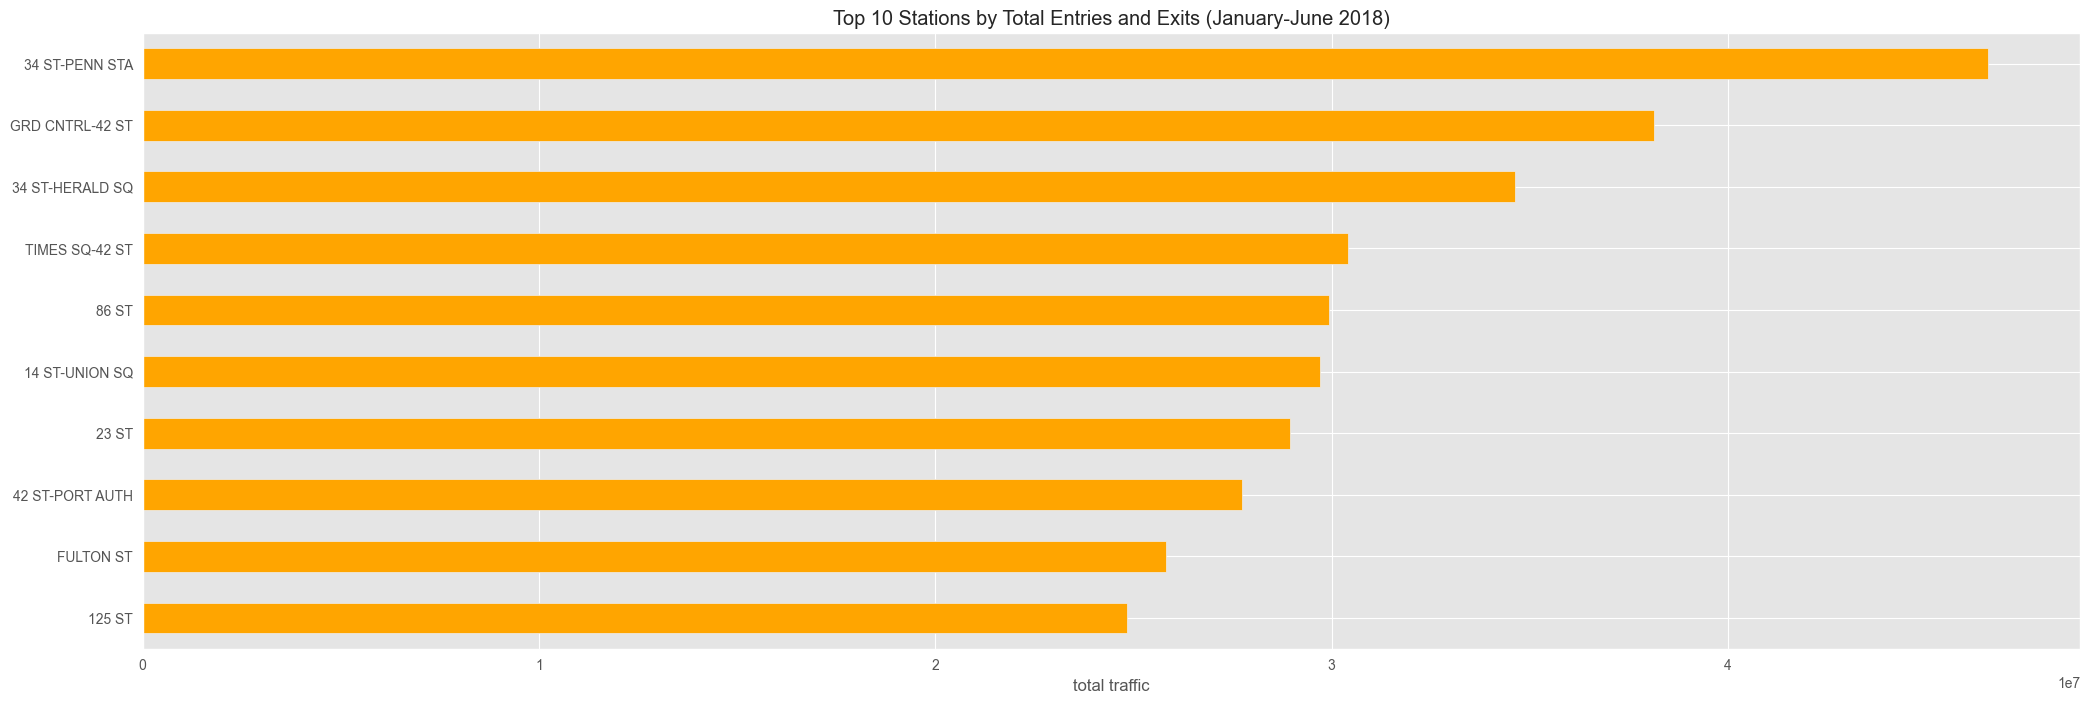

In [31]:
top_10 =mta_h1.groupby(['Station']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False).head(10)

fig, ax = plt.subplots(figsize=(25, 8))
top_10.sort_values(by = 'busy',ascending=True).plot(kind='barh', color ='orange',ax=ax)
ax.set(title='Top 10 Stations by Total Entries and Exits (January-June 2018)', xlabel='total traffic', ylabel='')
ax.legend().set_visible(False)

In [32]:
mta_penn = mta_h1[mta_h1['Station'] == '34 ST-PENN STA']
print('Number of turnstiles at 34-PENN STATION: %d' % len(mta_penn.turnstile.unique()))

Number of turnstiles at 34-PENN STATION: 112


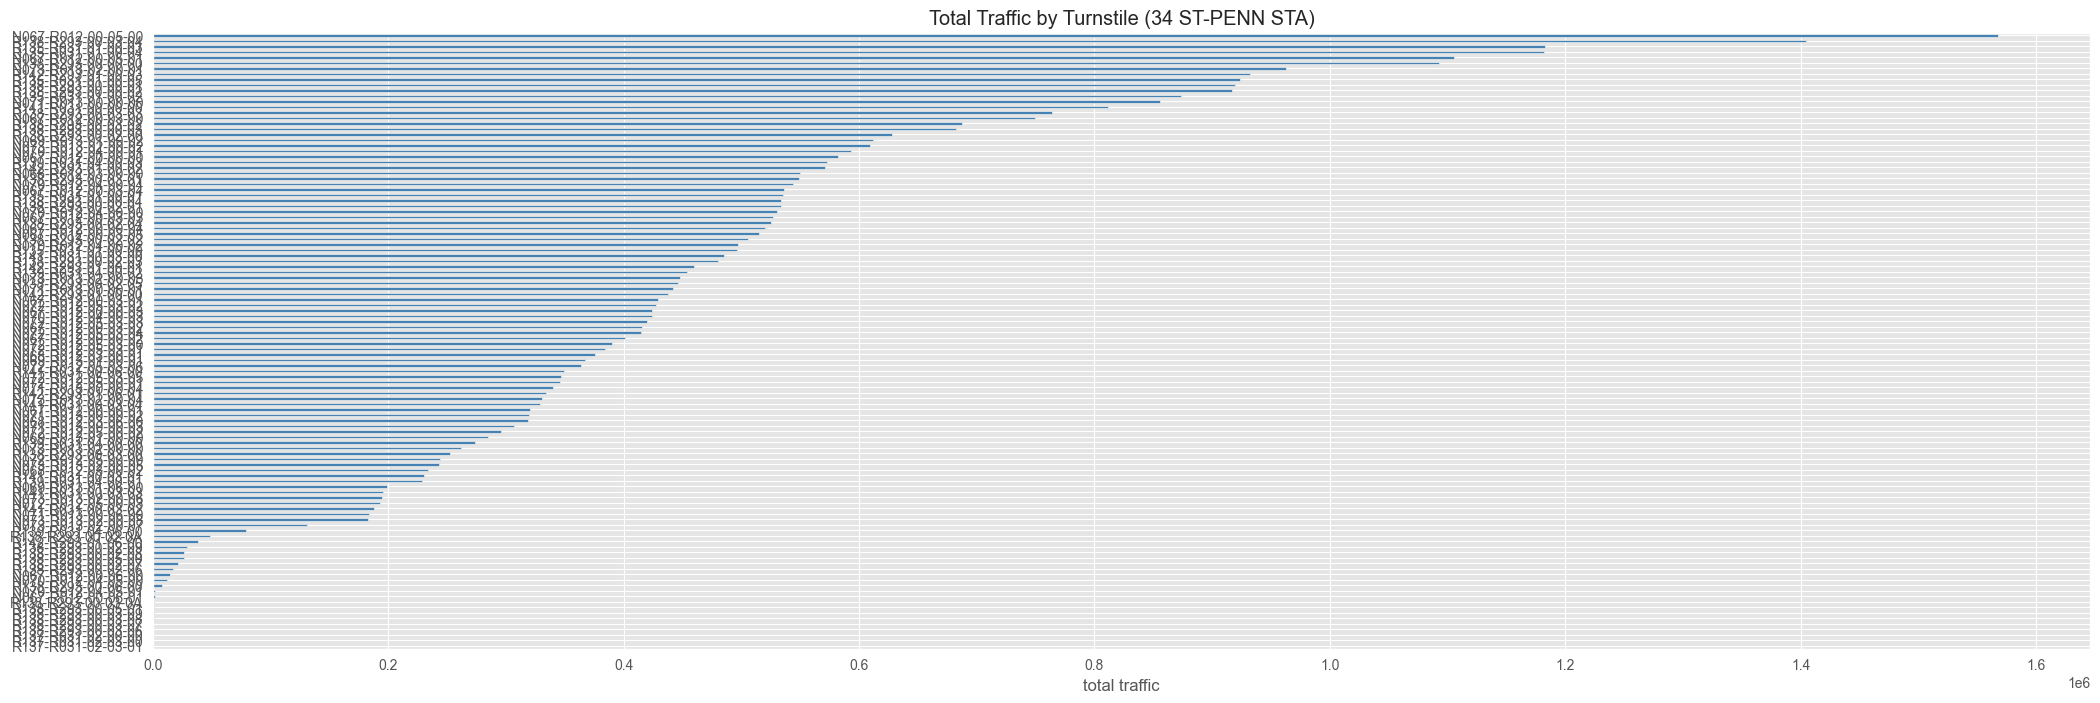

In [33]:
penn_turnstile =mta_penn.groupby(['turnstile']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False)

fig, ax = plt.subplots(figsize=(25, 8))
penn_turnstile.sort_values(by = 'busy',ascending=True).plot(kind='barh', color ='steelblue',ax=ax)
ax.set(title='Total Traffic by Turnstile (34 ST-PENN STA)', xlabel='total traffic', ylabel='')
ax.legend().set_visible(False)

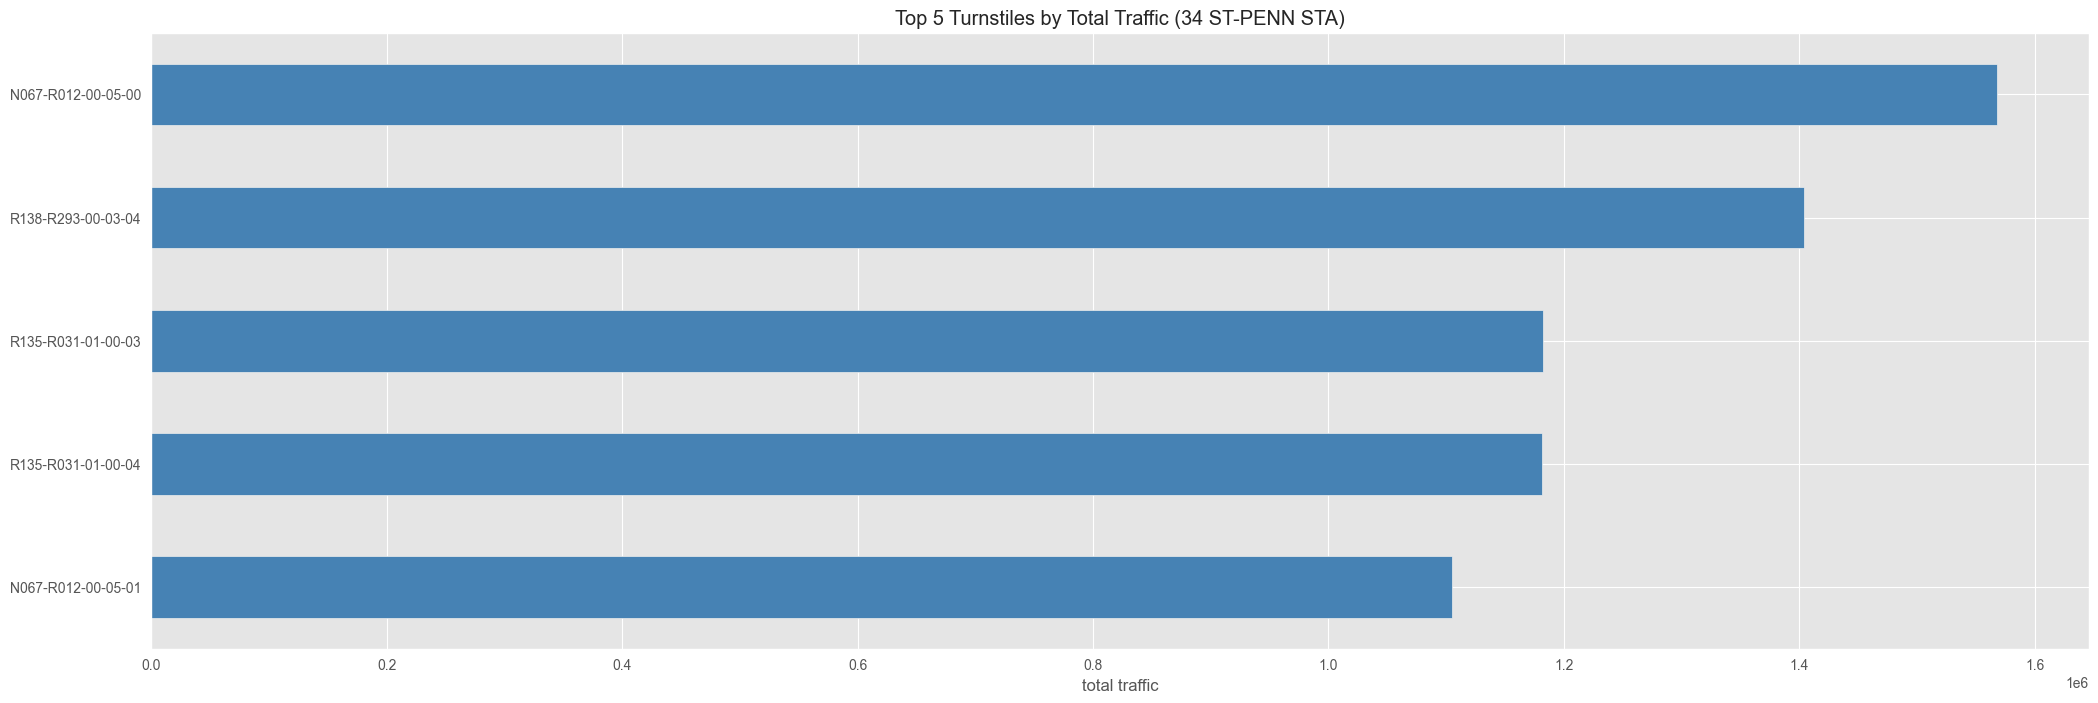

In [34]:
top_5 =mta_penn.groupby(['turnstile']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False).head()

fig, ax = plt.subplots(figsize=(25, 8))
top_5.sort_values(by = 'busy',ascending=True).plot(kind='barh', color ='steelblue',ax=ax)
ax.set(title='Top 5 Turnstiles by Total Traffic (34 ST-PENN STA)', xlabel='total traffic', ylabel='')
ax.legend().set_visible(False)

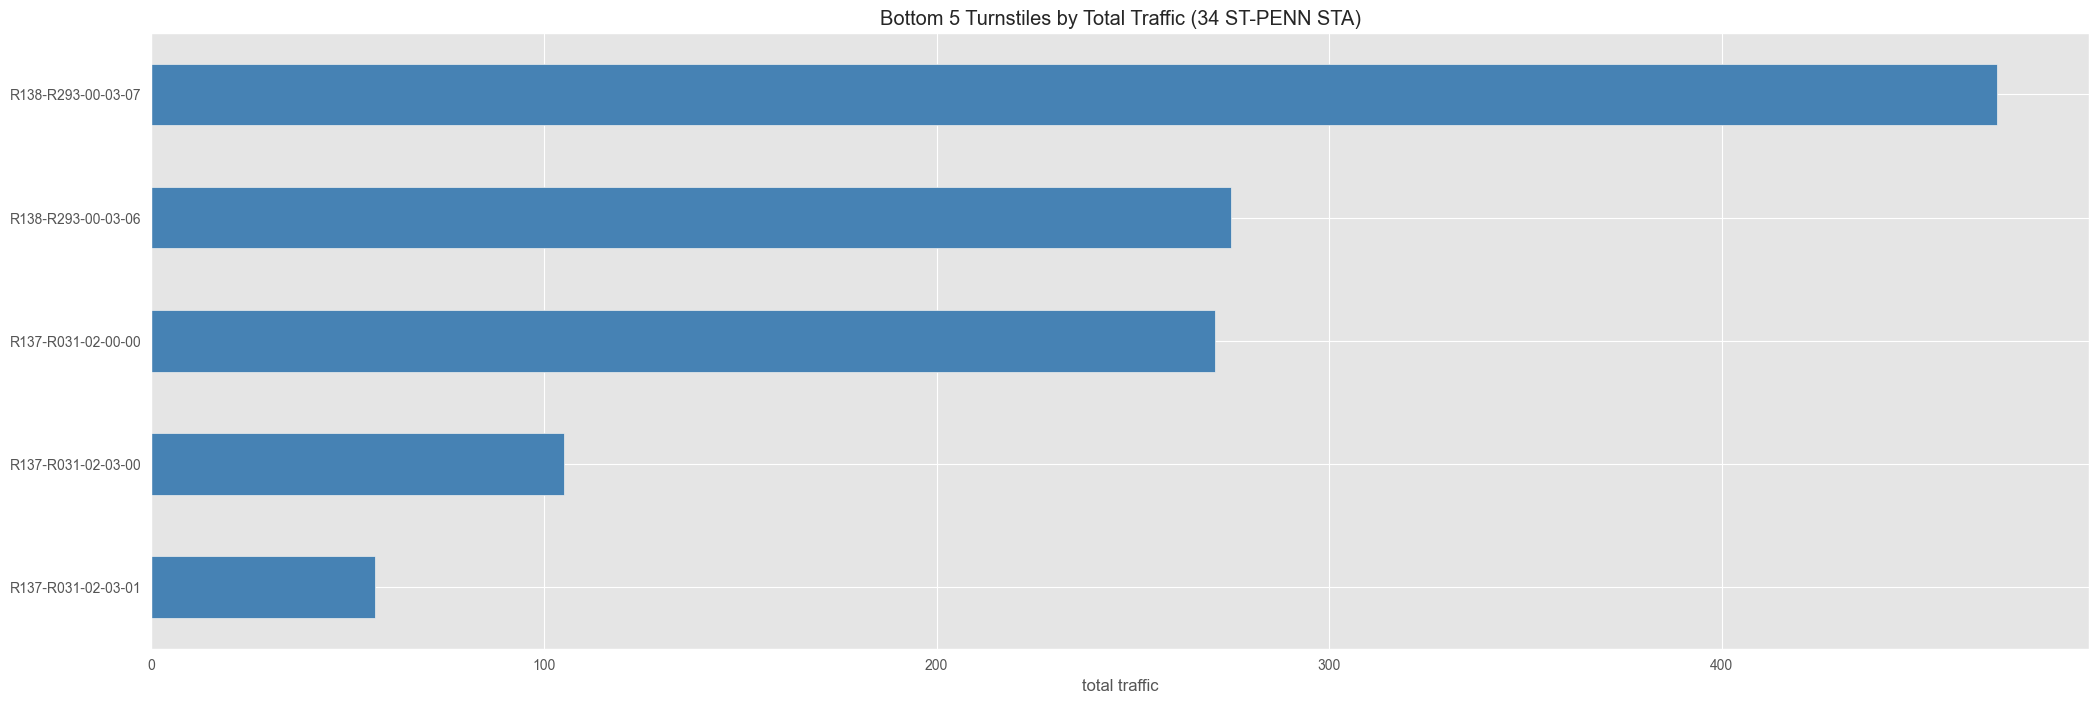

In [35]:
bottom_5 =mta_penn.groupby(['turnstile']).agg({'busy': sum}).sort_values(by = 'busy', ascending = True).head()

fig, ax = plt.subplots(figsize=(25, 8))
bottom_5.sort_values(by = 'busy',ascending=True).plot(kind='barh', color ='steelblue',ax=ax)
ax.set(title='Bottom 5 Turnstiles by Total Traffic (34 ST-PENN STA)', xlabel='total traffic', ylabel='')
ax.legend().set_visible(False)

In [37]:
mta_penn = mta_h1[(mta_h1['Station'] == '34 ST-PENN STA')]
mta_penn['Time'] = pd.to_datetime(mta_penn['Time'], format = '%H:%M:%S') # have to be datetime format so that we could resample
mta_penn_grouped = mta_penn.groupby(['Time']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False)
mta_penn_grouped.resample('60T',convention='end').sum().sort_values(by = 'busy', ascending = False).head()

,busy
Time,
1900-01-01 20:00:00,7302315.0
1900-01-01 16:00:00,4947721.0
1900-01-01 12:00:00,4877076.0
1900-01-01 19:00:00,3663124.0
1900-01-01 18:00:00,2866742.0


In [38]:
mta_h1busy = mta_h1[['Date', 'busy']].groupby(['Date']).sum().reset_index()
mta_h1busy['Date'] = pd.to_datetime(mta_h1busy['Date'])

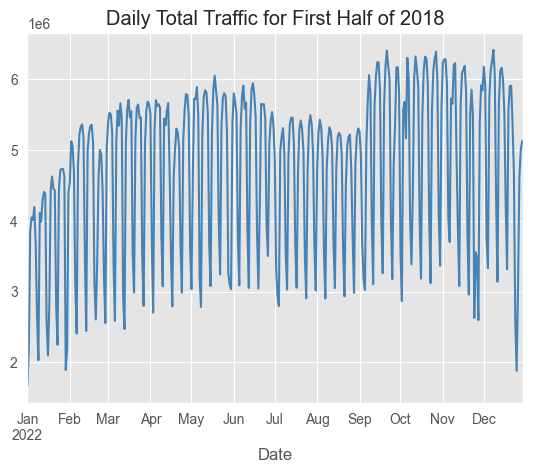

In [40]:
mta_h1busy.set_index('Date')['busy'].plot(color = 'steelblue')
plt.title('Daily Total Traffic for First Half of 2018') 
plt.show()

In [42]:
del [mta_h1busy]

In [44]:
mta_h1['weekday'] = (mta_h1['datetime']).dt.day_name
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mta_h1['weekday'] = pd.Categorical(mta_h1['weekday'], categories=weekdays, ordered = True)

In [45]:
weekday_ave = mta_h1[['entries_diff', 'exits_diff', 'busy', 'weekday']].groupby('weekday').sum().reset_index().sort_values(by = 'weekday')
weekday_ave['emgergency'] = (weekday_ave['entries_diff'] - weekday_ave['exits_diff'])/weekday_ave['busy']

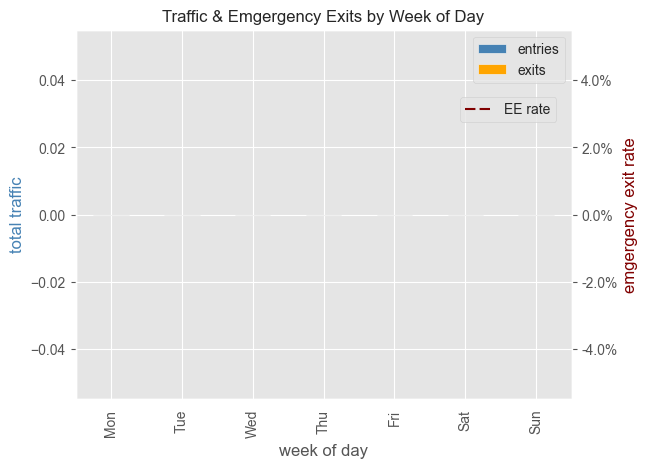

In [46]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

p1 = weekday_ave['busy'].plot(kind='bar', color='steelblue', ax=ax1, label = 'entries')
p1.legend(loc = 1)
p2 = weekday_ave['exits_diff'].plot(kind='bar', color='orange', ax=ax1, label = 'exits')
p2.legend(loc = 1)
p3 = weekday_ave['emgergency'].plot(kind='line', dashes = [5, 2], color='maroon', ax=ax2, label = 'EE rate')
p3.legend(loc = (0.775, 0.75)) 

plt.xticks((0,1,2,3,4,5,6),('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
ax1.set_xlabel('week of day')
ax1.set_ylabel('total traffic', color='steelblue')

ax2.set_ylabel('emgergency exit rate', color='maroon')
ax2.grid(False)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y))) 
plt.title('Traffic & Emgergency Exits by Week of Day', size = 12) 
plt.show()

In [50]:
mta_penn = mta_h1[mta_h1['Station'] == '34 ST-PENN STA'].groupby(by = 'Date').agg({'busy' : sum}).reset_index()
mta_penn['Date'] = pd.to_datetime(mta_penn['Date'])
mta_penn['month'] = mta_penn['Date'].dt.month
penn_month = mta_penn[['month', 'busy']].groupby('month')
penn_mean = penn_month.mean()

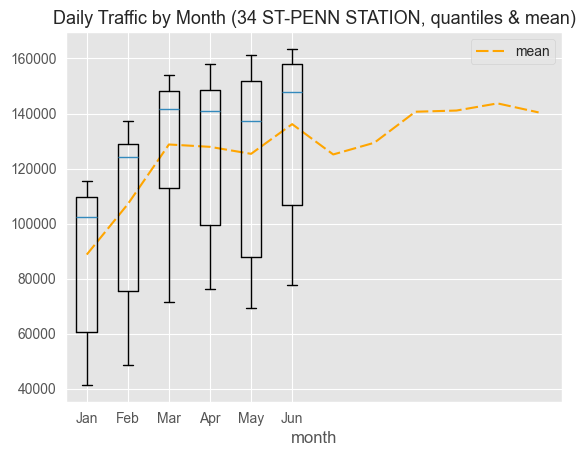

In [51]:
mta_penn['month']=mta_penn['month'].apply(str)
p1 = penn_mean.plot(kind='line', color = 'orange', dashes = (6, 2)) 
p1.legend(['mean'])
plt.boxplot([mta_penn[mta_penn['month'] == '1']['busy'].values,mta_penn[mta_penn['month'] == '2']['busy'].values,mta_penn[mta_penn['month'] == '3']['busy'].values,mta_penn[mta_penn['month'] == '4']['busy'].values,mta_penn[mta_penn['month'] == '5']['busy'].values,mta_penn[mta_penn['month'] == '6']['busy'].values])
plt.xticks((1,2,3,4,5,6),('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'))
plt.title('Daily Traffic by Month (34 ST-PENN STATION, quantiles & mean)', size = 13)
plt.show()

In [52]:
station_of_interest = '34 ST-PENN STA'
mta_penn = mta_h1[mta_h1['Station'] == station_of_interest]
time_interval = '4H'

mta_penn.head()

,turnstile,Station,datetime,Date,Time,entries_diff,exits_diff,busy,weekday
2901200,N067-R012-00-00-00,34 ST-PENN STA,2022-01-01 03:00:00,01/01/2022,03:00:00,0.0,0.0,0.0,NaN
2901201,N067-R012-00-00-00,34 ST-PENN STA,2022-01-01 07:00:00,01/01/2022,07:00:00,5.0,6.0,11.0,NaN
2901202,N067-R012-00-00-00,34 ST-PENN STA,2022-01-01 11:00:00,01/01/2022,11:00:00,12.0,45.0,57.0,NaN
2901203,N067-R012-00-00-00,34 ST-PENN STA,2022-01-01 15:00:00,01/01/2022,15:00:00,25.0,71.0,96.0,NaN
2901204,N067-R012-00-00-00,34 ST-PENN STA,2022-01-01 19:00:00,01/01/2022,19:00:00,44.0,73.0,117.0,NaN


In [53]:
stations_day_time = mta_penn[['Station', 'datetime', 'entries_diff','exits_diff','busy']]
stations_day_time_group = stations_day_time.groupby(['Station','datetime'], as_index=False)
stations_day_time = stations_day_time_group[['entries_diff', 'exits_diff','busy']].sum()
rounded_day_time = stations_day_time.set_index('datetime').groupby(['Station'])
rounded_day_time = rounded_day_time.resample(time_interval, convention='end').sum()

print ('Station of interest: ' + station_of_interest)
print ('Sample size before resampling:')
print (len(stations_day_time[stations_day_time.Station == station_of_interest]))
print ('Sample size after resampling:')
print (len(rounded_day_time.loc[station_of_interest]))
rounded_day_time = rounded_day_time.reset_index()

Station of interest: 34 ST-PENN STA
Sample size before resampling:
4542
Sample size after resampling:
2184


ValueError: cannot insert Station, already exists

In [54]:
rounded_day_time.head()

Station  \
Station        datetime                                            
34 ST-PENN STA 2022-01-01 00:00:00  34 ST-PENN STA34 ST-PENN STA   
               2022-01-01 04:00:00  34 ST-PENN STA34 ST-PENN STA   
               2022-01-01 08:00:00  34 ST-PENN STA34 ST-PENN STA   
               2022-01-01 12:00:00  34 ST-PENN STA34 ST-PENN STA   
               2022-01-01 16:00:00  34 ST-PENN STA34 ST-PENN STA   

                                    entries_diff  exits_diff     busy  
Station        datetime                                                
34 ST-PENN STA 2022-01-01 00:00:00           0.0         0.0      0.0  
               2022-01-01 04:00:00         871.0      1838.0   2709.0  
               2022-01-01 08:00:00        1909.0      3622.0   5531.0  
               2022-01-01 12:00:00        4629.0      7301.0  11930.0  
               2022-01-01 16:00:00        5860.0      9787.0  15647.0

In [55]:
stations_day_time = rounded_day_time
stations_day_time['DAY'] = stations_day_time['datetime'].dt.dayofweek
stations_day_time['TIME'] = stations_day_time['datetime'].dt.time

KeyError: 'datetime'

In [56]:
stations_day_time_group = stations_day_time.groupby(['Station','DAY','TIME'])
stations_day_time_group = stations_day_time_group['entries_diff'].mean().reset_index()

ValueError: 'Station' is both an index level and a column label, which is ambiguous.

In [57]:
draw_station = stations_day_time_group

station_heatmap = draw_station.set_index(['DAY', 'TIME']).entries_diff.unstack(0)
weekdays = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
station_heatmap.columns = [weekdays[c] for c in station_heatmap.columns]

fig, ax = plt.subplots(figsize=(12, 8))
ax.set(title='Entries: ' + station_of_interest , xlabel='', ylabel='Time')
sns.heatmap(station_heatmap,ax=ax, cmap='Blues')
plt.show()

AttributeError: 'DataFrameGroupBy' object has no attribute 'set_index'